In [3]:
#from google.colab import drive
#drive.mount('/content/drive')
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('/content/drive/My Drive/data/names/*.txt'))

['/content/drive/My Drive/data/names/Greek_test.txt', '/content/drive/My Drive/data/names/Irish_train.txt', '/content/drive/My Drive/data/names/Korean_train.txt', '/content/drive/My Drive/data/names/Irish_test.txt', '/content/drive/My Drive/data/names/Italian_test.txt', '/content/drive/My Drive/data/names/Italian_train.txt', '/content/drive/My Drive/data/names/Greek_train.txt', '/content/drive/My Drive/data/names/Japanese_test.txt', '/content/drive/My Drive/data/names/Japanese_train.txt', '/content/drive/My Drive/data/names/Korean_test.txt', '/content/drive/My Drive/data/names/Polish_test.txt', '/content/drive/My Drive/data/names/Portuguese_train.txt', '/content/drive/My Drive/data/names/Polish_train.txt', '/content/drive/My Drive/data/names/Russian_train.txt', '/content/drive/My Drive/data/names/Russian_test.txt', '/content/drive/My Drive/data/names/Portuguese_test.txt', '/content/drive/My Drive/data/names/Scottish_test.txt', '/content/drive/My Drive/data/names/Spanish_test.txt', '/co

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import os

import unicodedata
import string

all_letters = string.ascii_letters + " .,;"
n_letters = len(all_letters)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [0]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/drive/My Drive/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

#n_categories = len(all_categories)

#print('# categories:', n_categories, all_categories)

In [0]:
#Slicing the train and test data
import re

def slicedict(d,s):
  return{k:v for k,v in d.items() if k.endswith(s)}

train_dict = slicedict(category_lines,'train')
test_dict  = slicedict(category_lines,'test')

train_categories = [s for s in all_categories if "train" in s]
test_categories  = [s for s in all_categories if "test" in s]

train_categories = ([s.replace('_train', '') for s in train_categories])
test_categories = ([s.replace('_test', '') for s in test_categories])

n_categories = len(train_categories)

train_data = {}
test_data  = {}

for k,v in train_dict.items():
  
  val = v[0]
  val = re.findall('[A-Z][^A-Z]*', val)
  train_data[k] = val

for k,v in test_dict.items():
  
  val = v[0]
  val = re.findall('[A-Z][^A-Z]*', val)
  test_data[k] = val

In [0]:
#Please run this code again if there's an error in the step below
for key,val in train_data.items():
  key1 = key.replace('_train', '')
  train_data[key1] = train_data.pop(key)

for key,val in test_data.items():
  key1 = key.replace('_test', '')
  test_data[key1] = test_data.pop(key)

for key,val in train_data.items():
  key1 = key.replace('_train', '')
  train_data[key1] = train_data.pop(key)

for key,val in test_data.items():
  key1 = key.replace('_test', '')
  test_data[key1] = test_data.pop(key)

In [8]:
print(test_data['French'][:5])
print(train_data['French'][:5])

train_data.keys()

['Tailler', 'Janvier', 'Babineaux', 'Baudin', 'Leclerc']
['Paternoster', 'Faucheux', 'Vincent', 'Parris', 'Bonnay']


dict_keys(['German', 'English', 'French', 'Irish', 'Japanese', 'Portuguese', 'Polish', 'Russian', 'Korean', 'Italian', 'Greek', 'Spanish', 'Scottish', 'Dutch', 'Vietnamese', 'Czech', 'Arabic', 'Chinese'])

In [9]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


In [0]:
#Embedding with GRU class

import torch.nn as nn

class BiRNN(nn.Module): 

    def __init__(self, input_size, hidden_size, output_size):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.word_embeddings = nn.Embedding(56, 56)
        self.lstm_cell = nn.LSTM(input_size, hidden_size,  bidirectional=True) #LSTM cell
        self.h2o = nn.Linear(hidden_size*2, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
      
    def forward(self, input, hidden):

        one = torch.tensor(1)
        idx = (input == one).nonzero().flatten()
        idx = idx.tolist()[1]

        input = self.word_embeddings(torch.LongTensor([idx]))        
        output, hidden = self.lstm_cell(input.view(1,1,-1), hidden)
        #print(len(hidden))
        #print(len(hidden[0]))
        output = self.h2o(output)
        output = self.softmax(output)
        return output.view(1,-1), hidden

    def init_hidden(self):
        return (torch.zeros(1,1, self.hidden_size), torch.zeros(1,1, self.hidden_size))

n_hidden = 128
birnn = BiRNN(n_letters, n_hidden, n_categories)

In [0]:
input = letterToTensor('a')
hidden =torch.zeros(2, 1, n_hidden), torch.zeros(2, 1, n_hidden)

output, next_hidden = birnn(input, hidden)

input = lineToTensor('Albert')
hidden =torch.zeros(2, 1, n_hidden), torch.zeros(2, 1, n_hidden)

output, next_hidden = birnn(input[0], hidden)

In [0]:
def categoryFromOutput(output):
    
    top_n, top_i = output.topk(1)
   # print(top_n,top_i,top_i[0].item())
    category_i = top_i[0].item()
    return train_categories[category_i], category_i

#print(categoryFromOutput(output))

In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(train_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([train_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, category_tensor)

category = Vietnamese / line = Diep tensor([11])
category = Italian / line = Mazza tensor([2])
category = Russian / line = Daraev tensor([7])
category = Chinese / line = Zhuan tensor([14])
category = Irish / line = Roach tensor([0])
category = Arabic / line = Shammas tensor([13])
category = Japanese / line = Atshushi tensor([4])
category = Japanese / line = Komatsu tensor([4])
category = Italian / line = Spano tensor([2])
category = Korean / line = Chou tensor([1])


In [0]:
criterion = nn.NLLLoss()
learning_rate = 0.05 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = (torch.zeros(2,1,128), torch.zeros(2,1,128))
    
    birnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = birnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in birnn.parameters():
       p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [20]:
import time
import math

#n_iters = 2
n_iters = 100000
print_every = 5000
plot_every = 1000

#Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
match = 0
total = 0

for iter in range(1, n_iters + 1):

    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
       
    guess, guess_i = categoryFromOutput(output)

    if guess == category:
       match = match + 1

    total = total + 1

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        #guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 41s) 0.6110 Solo / Spanish ✓
10000 10% (1m 22s) 0.1316 Ajnikoff / Russian ✓
15000 15% (2m 4s) 0.1456 Vuong / Vietnamese ✓
20000 20% (2m 46s) 0.3493 Ballaltick / Czech ✓
25000 25% (3m 28s) 1.3672 Ma / Korean ✗ (Vietnamese)
30000 30% (4m 9s) 0.0394 Tron / Vietnamese ✓
35000 35% (4m 50s) 1.2107 Cleirich / Czech ✗ (Irish)
40000 40% (5m 32s) 0.5223 Muso / Japanese ✓
45000 45% (6m 13s) 0.7125 Jizdik / Russian ✓
50000 50% (6m 54s) 0.0008 Tsuchie / Japanese ✓
55000 55% (7m 35s) 0.0087 Mackay / Scottish ✓
60000 60% (8m 17s) 0.0041 O / Irish ✓
65000 65% (8m 57s) 0.0298 Schroeder / German ✓
70000 70% (9m 37s) 0.0317 Halloran / Irish ✓
75000 75% (10m 17s) 0.5899 Mari / Italian ✓
80000 80% (10m 58s) 0.1230 Aonghuis / Irish ✓
85000 85% (11m 38s) 0.0392 Yeon / Korean ✓
90000 90% (12m 18s) 0.0944 Di pietro / Italian ✓
95000 95% (12m 58s) 0.1533 Mari / Italian ✓
100000 100% (13m 38s) 0.0024 Sokal / Polish ✓


We observe that there **are no NaN values.**

In [21]:
acc_train = match/total * 100
acc_train

80.471

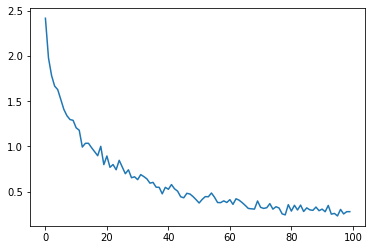

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

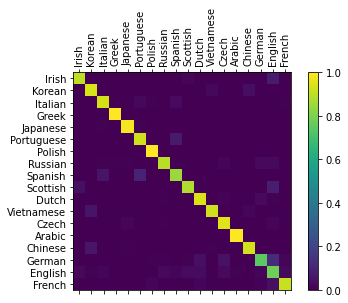

In [24]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = (torch.zeros(2,1,128), torch.zeros(2,1,128))

    for i in range(line_tensor.size()[0]):
        output, hidden = birnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = train_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + train_categories, rotation=90)
ax.set_yticklabels([''] + train_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

We observe bright spots for languages like Greek which means that there is a high error rate for them.

In [0]:
n_predictions = 1
match = 0
total = 0
confusion = torch.zeros(n_categories, n_categories)

for i in range(len(test_data)):

  category = test_categories[i]
  line     = test_data[category]
  #print(line)
  
  for j in range(len(line)):
    with torch.no_grad():
        
        input_line = line[j]

        output = evaluate(lineToTensor(input_line))
       
        #Confusion Matrix
        guess, guess_i = categoryFromOutput(output)
        category_i = train_categories.index(category)
        confusion[category_i][guess_i] += 1

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        value = topv[0][0].item()
        category_index = topi[0][0].item()
        #Keeping the category order same as the training data
        predictions.append([value, train_categories[category_index]])

        if train_categories[category_index] == category:
          match = match + 1
        
        total = total + 1

In [26]:
acc_test = match/total * 100
acc_test

77.72301626416954

In [27]:
def predict(input_line, n_predictions=1):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        print(category)
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, train_categories[category_index]))
            predictions.append([value, train_categories[category_index]])


predict('Dovesky')


> Dovesky
French
(-0.13) Russian


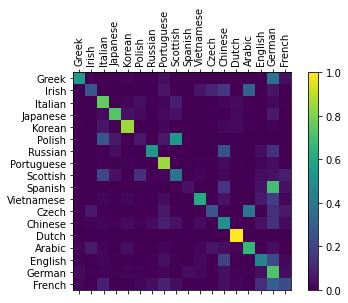

In [28]:

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + test_categories, rotation=90)
ax.set_yticklabels([''] + test_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()